# Avaliação Cientista de Dados

Existem três arquivos a serem considerados, adult.data, adult.test e old.adult.names. A base apresenta diversas informações sobre as pessoas, como idade, escolaridade, estado civil, etc., bem como a variável resposta de interesse "class", que informa em qual categoria a renda anual da pessoa se enquadra.

Tarefas da avaliação:
- Carregar a base de dados adult.data e adult.test
- Realizar uma análise inicial dos dados: Quais foram os problemas encontrado? Como tratar os problemas?
- Fazer uma análise exploratória dos dados: Quais informações interessantes encontrei. (ex: distribuições de variáveis, outliers, correlações, etc)
- A base de dados é desbalanceada para a variável resposta "class". Usar uma técnica para balancear os dados, justificando a escolha.


## Importação e instalação de bibliotecas


In [1]:
!pip install imbalanced-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, precision_score
from sklearn.metrics import confusion_matrix, f1_score, recall_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


## Funções 

In [3]:
sns.set_style('darkgrid')

In [4]:
# Função criada para plotar um gráfico que compara a distribuição de variáveis continuas
#dos dois datasets para validar a confiabilidade das duas bases.
# A intenção é poder atestar que os dados de treino e testes além 

def histograma_de_comparacao(nome_coluna:str):
    if type(df_train[nome_coluna][0]) == np.int64:
        fig, (ax1,ax2) = plt.subplots(1, 2,constrained_layout=True)

        plt.suptitle("Histograma de comparação das colunas "+nome_coluna, fontsize = 16)

        sns.histplot(y = df_train[nome_coluna],
                     bins = len(df_train[nome_coluna].unique()), 
                     ax=ax1, color = 'brown',
                     stat="density")

        sns.kdeplot(y=df_train[nome_coluna],
                    color = 'r', ax = ax1)

        sns.histplot(y = df_test[nome_coluna],
                     bins = len(df_test[nome_coluna].unique()), 
                     ax=ax2, color = 'brown',
                     stat='density')

        sns.kdeplot(y=df_test[nome_coluna],
                    color='red',ax=ax2)

        ax1.set_title('Treino')
        ax2.set_title('Teste')

        plt.show()
    else:
        fig, (ax1,ax2) = plt.subplots(1, 2,constrained_layout=True)

        plt.suptitle("Histograma de comparação das colunas "+nome_coluna, fontsize = 16)

        sns.histplot(y = df_train[nome_coluna].sort_values(),
                     bins = len(df_train[nome_coluna].unique()), 
                     ax=ax1, color = 'brown',
                     stat="density")


        sns.histplot(y = df_test[nome_coluna].sort_values(),
                     bins = len(df_test[nome_coluna].unique()), 
                     ax=ax2, color = 'brown',
                     stat='density')

        ax1.set_title('Treino')
        ax2.set_title('Teste')
        ax2.yaxis.set_ticklabels([])

        plt.show()

In [5]:
# Criação de uma função para gerar uma tabela de comparação da frequencia dos dados categoricos

def comparacao_categorica(coluna:str):
    return pd.concat(
                     [df_train[coluna].sort_values().value_counts(normalize=True),
                     df_test[coluna].sort_values().value_counts(normalize=True)],
                     axis = 1, keys = ['treino','teste']
                    )

In [6]:
# Aqui estou me propondo a preencher os valores NaN, porém de forma que seja possível manter a distribuição dos valores.

# A ideia é usar o np.random.choice para fazer o preenchimento desses NaN,criando uma amostra baseando nos valores e distribuição existentes
# Pra isso se faz necessário construir duas variáveis:
# frequencia_coluna = representa a frequencia dos valores da variável
# workclass_vazio = que será usado como indexador dos campos vazios e contabiliza os campos vazios.

# Essa função pega os valores da coluna, contabiliza quantas amostras terá que gerar e depois entende a frequencia desses valores,
# Assim é possível preencher esses valores vazios com essa amostra gerada na função

def preenche_coluna(df:pd.DataFrame,coluna:str):
    frequencia_coluna = df[coluna].value_counts(normalize=True)
    workclass_vazio = df[coluna].isnull()
    df.loc[workclass_vazio,coluna] = np.random.choice(frequencia_coluna.index, size=len(df[workclass_vazio]),p=frequencia_coluna.values)
    return df

In [7]:
# Criação de faixa etárias para um plot de cruzamento de dados de idade com Renda

def faixa_etarias(x):
    x = int(x)
    x = abs(x)
    if( 18 < x < 31 ):
        return "19-30"
    if( 30 < x < 41 ):
        return "31-40"
    if( 40 < x < 51 ):
        return "41-50"
    if( 50 < x < 61 ):
        return "51-60"
    if( 60 < x < 71 ):
        return "61-70"
    else:
        return "Acima de 70"

## Carregamento dos datasets

In [8]:
# Como as bases não tem os nomes das colunas, me baseei no arquivo 'old.adult.names' para pegar o nome das colunas, mas transformando em snake_case
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
           'relationship', 'race','sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'class']


# leitura dos datasets
df_train = pd.read_csv('adult.data', names=columns)
df_test = pd.read_csv('adult.test', names=columns, skiprows= 1)


In [9]:
df_train.shape

(32561, 15)

In [10]:
df_test.shape

(16281, 15)

## Análise inicial dos dados

### Checagem de confiabilidade dos datasets de treino e teste.

A ideia dessa etapa é gerar insights que validem a confiabilidade de relação entre os dois datasets

In [11]:
# Visualizar as primeiras linhas para ver os dados das primeiras colunas e ver o comportamento do dataset
df_train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [12]:
# Visualizar as primeiras linhas para verificar os dados das primeiras colunas e ver o comportamento do dataset
df_test.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [13]:
# Concatenar a descrição dos dois datasets para os valores numéricos

pd.concat(
          [df_train.describe().T,
          df_test.describe().T], 
          axis = 0, 
          keys = ['train','test'] 
         )

# Nesse describe é possível ver que os dados são bem parecidos, 
#as médias tem pouca mudança entre si, assim como os desvios e quartis.
# Seria possível já chegar na conclusão de que os dados de treino e teste foram bem 
#separados por suas semelhanças, porém quero confirmar isso visualmente

count           mean            std      min  \
train age             32561.0      38.581647      13.640433     17.0   
      fnlwgt          32561.0  189778.366512  105549.977697  12285.0   
      education_num   32561.0      10.080679       2.572720      1.0   
      capital_gain    32561.0    1077.648844    7385.292085      0.0   
      capital_loss    32561.0      87.303830     402.960219      0.0   
      hours_per_week  32561.0      40.437456      12.347429      1.0   
test  age             16281.0      38.767459      13.849187     17.0   
      fnlwgt          16281.0  189435.677784  105714.907671  13492.0   
      education_num   16281.0      10.072907       2.567545      1.0   
      capital_gain    16281.0    1081.905104    7583.935968      0.0   
      capital_loss    16281.0      87.899269     403.105286      0.0   
      hours_per_week  16281.0      40.392236      12.479332      1.0   

                           25%       50%       75%        max  
train age                 28.0      37.0      48.0       90.0  
      fnlwgt          117827.0  178356.0  237051.0  1484705.0  
      education_num        9.0      10.0      12.0       16.0  
      capital_gain         0.0       0.0       0.0    99999.0  
      capital_loss         0.0       0.0       0.0     4356.0  
      hours_per_week      40.0      40.0      45.0       99.0  
test  age                 28.0      37.0      48.0       90.0  
      fnlwgt          116736.0  177831.0  238384.0  1490400.0  
      education_num        9.0      10.0      12.0       16.0  
      capital_gain         0.0       0.0       0.0    99999.0  
      capital_loss         0.0       0.0       0.0     3770.0  
      hours_per_week      40.0      40.0      45.0       99.0

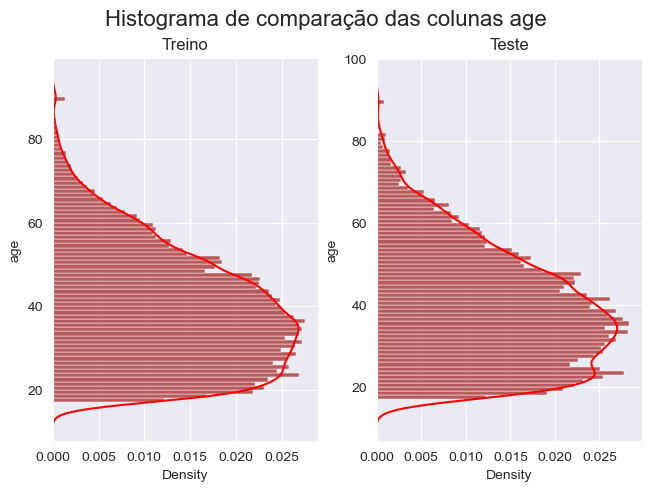

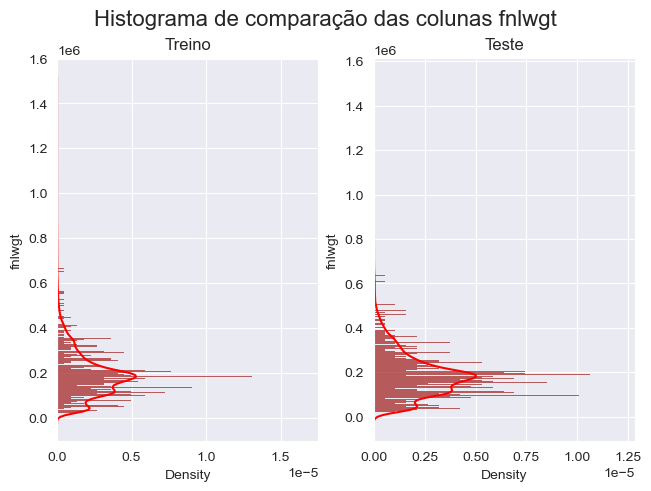

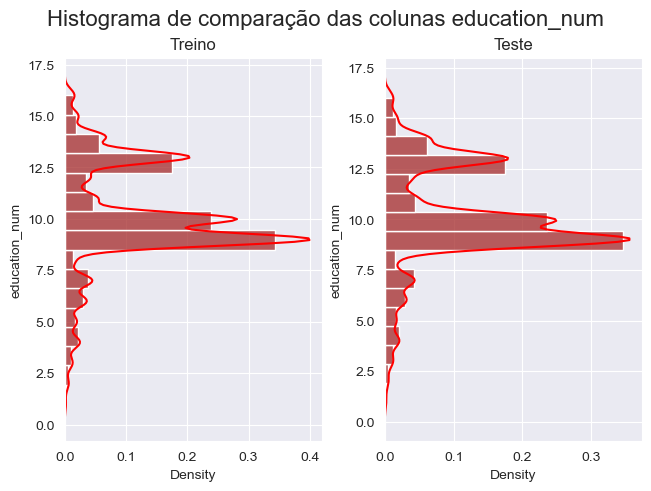

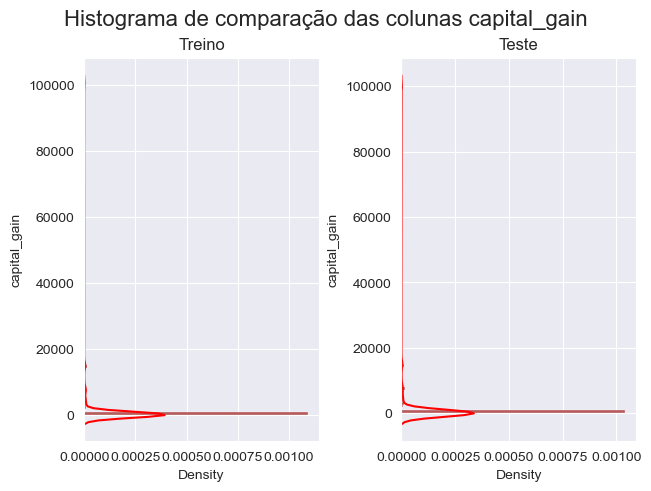

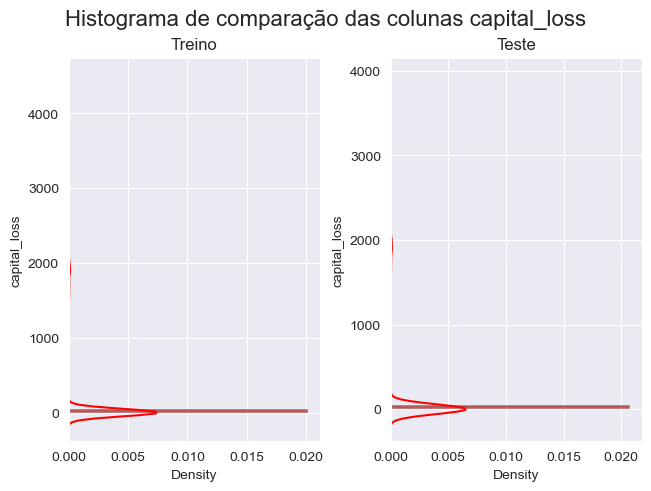

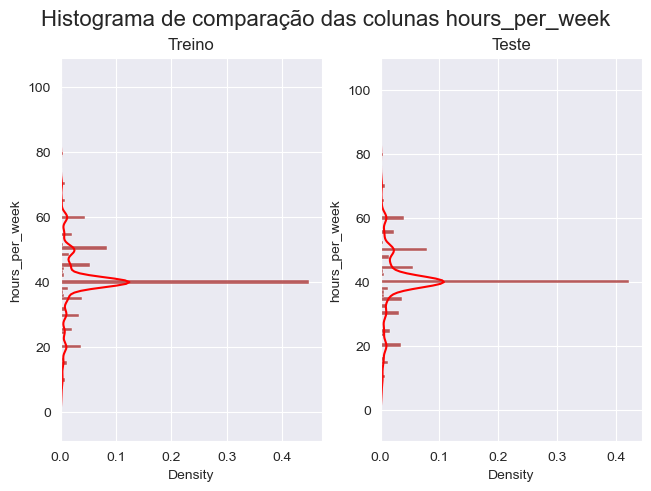

In [14]:
# Um looping pra gerar todos os gráficos de histograma uma vez só

for column in df_train.describe().columns:
    histograma_de_comparacao(str(column))
    
# Abaixo dos gráficos ficarão os comentários sobre eles

É possível ver uma diferença inexpressível nas distribuições dos valores continuos dentro das variáveis.

O segundo passo é entender também se o mesmo acontece com as variáveis categórias, seguiremos a lógica usada para as variáveis numéricas e faremos um estudo dos dados de forma tabular e depois gráfica.

In [15]:
# Criação de uma lista de colunas categóricas para fazer a visualização comparativa das distribuições de dados

colunas_cat = []

for i in df_train.columns:
    if i in df_train.describe().columns:
        pass
    else:
        colunas_cat.append(i)

In [16]:
for coluna in colunas_cat:
    print(comparacao_categorica(coluna))

                     treino     teste
 Private           0.697030  0.688533
 Self-emp-not-inc  0.078038  0.081138
 Local-gov         0.064279  0.064062
 ?                 0.056386  0.059149
 State-gov         0.039864  0.041951
 Self-emp-inc      0.034274  0.035563
 Federal-gov       0.029483  0.028991
 Without-pay       0.000430  0.000430
 Never-worked      0.000215  0.000184
                 treino     teste
 HS-grad       0.322502  0.324489
 Some-college  0.223918  0.220318
 Bachelors     0.164461  0.163995
 Masters       0.052916  0.057367
 Assoc-voc     0.042443  0.041705
 11th          0.036086  0.039125
 Assoc-acdm    0.032769  0.032799
 10th          0.028654  0.028008
 7th-8th       0.019840  0.018979
 Prof-school   0.017690  0.015847
 9th           0.015786  0.014864
 12th          0.013298  0.013758
 Doctorate     0.012684  0.011117
 5th-6th       0.010227  0.010810
 1st-4th       0.005160  0.004852
 Preschool     0.001566  0.001965
                          treino     teste

É possível ver que a diferença entre distribuições desses dados não-numéricos também são irrelevantes estatisticamente e para nossa análise. Segue abaixo também uma visualização gráfica dessas distribuições.

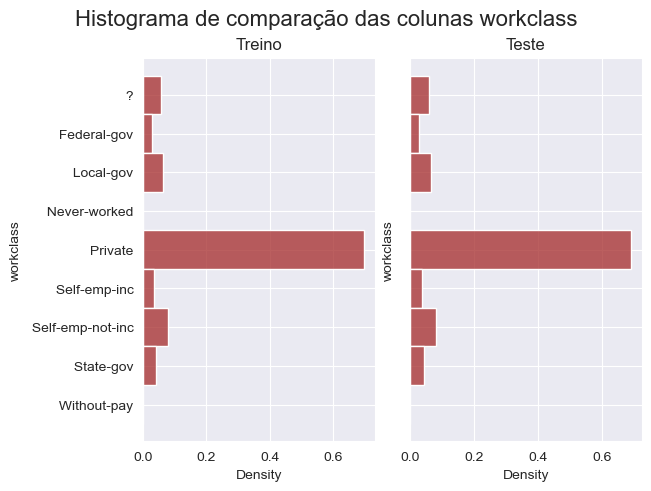

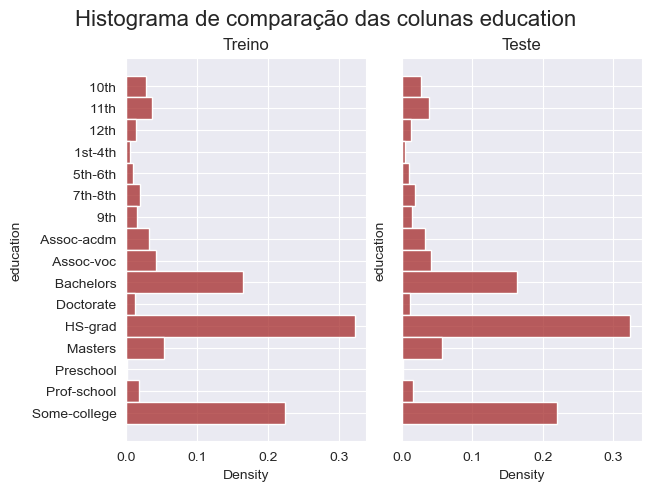

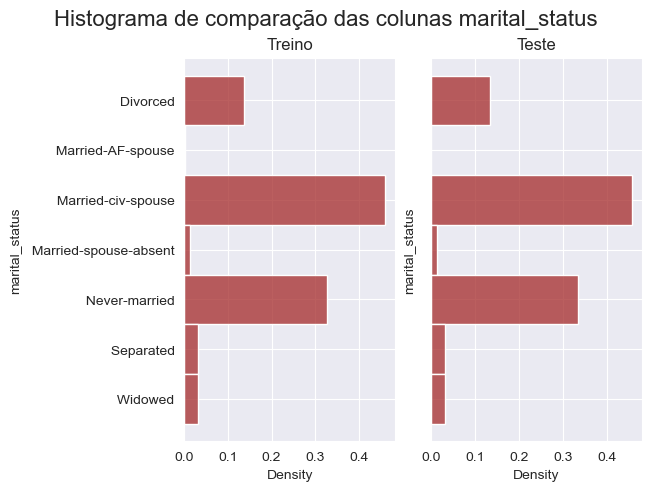

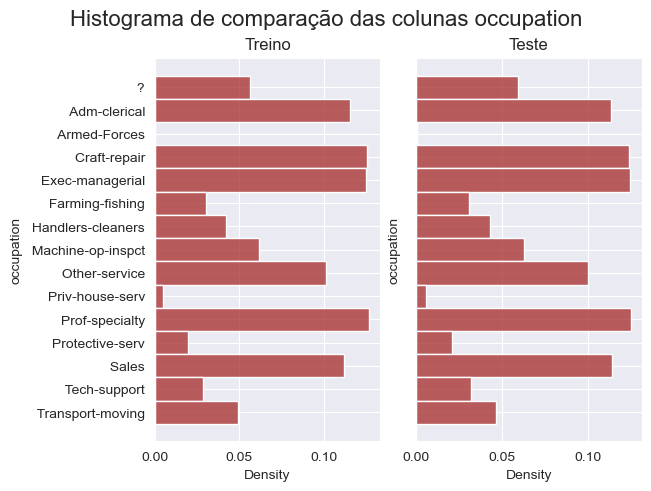

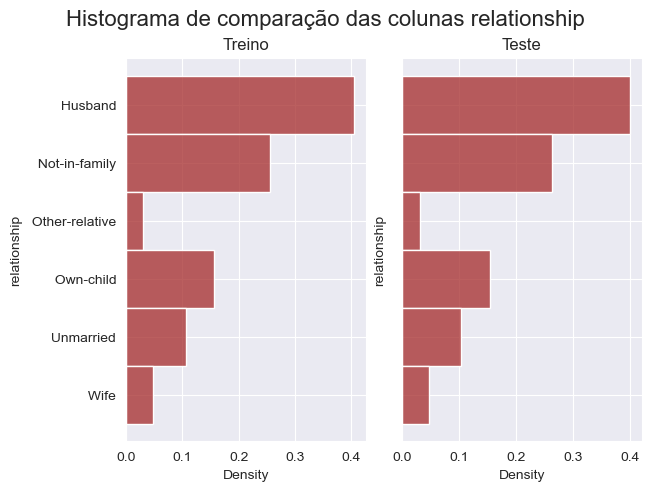

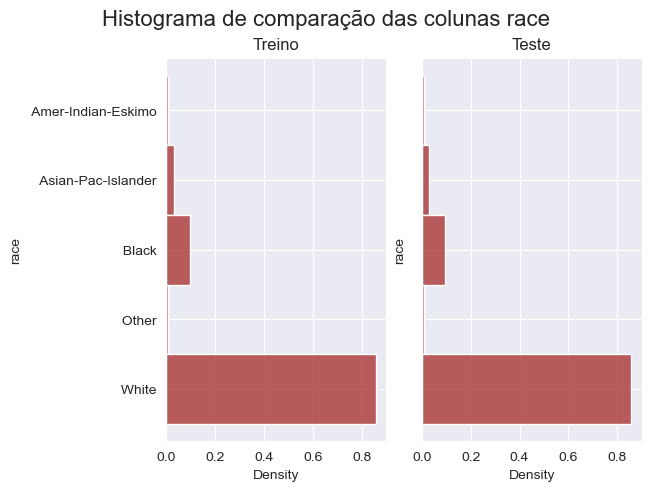

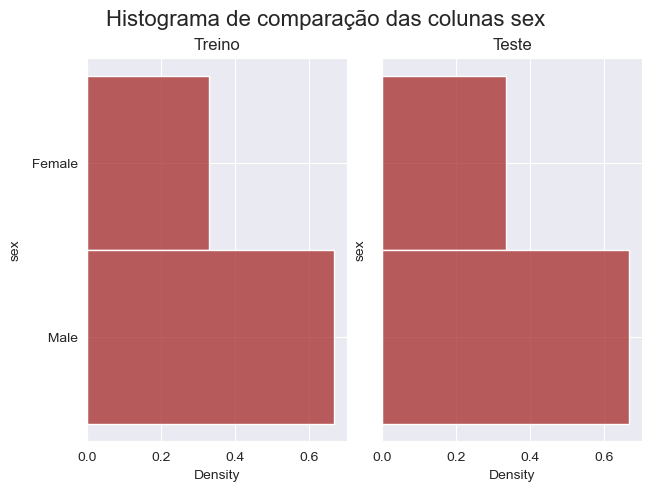

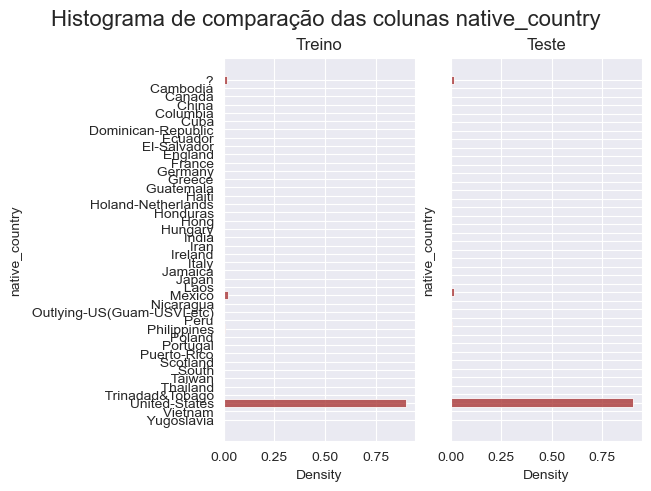

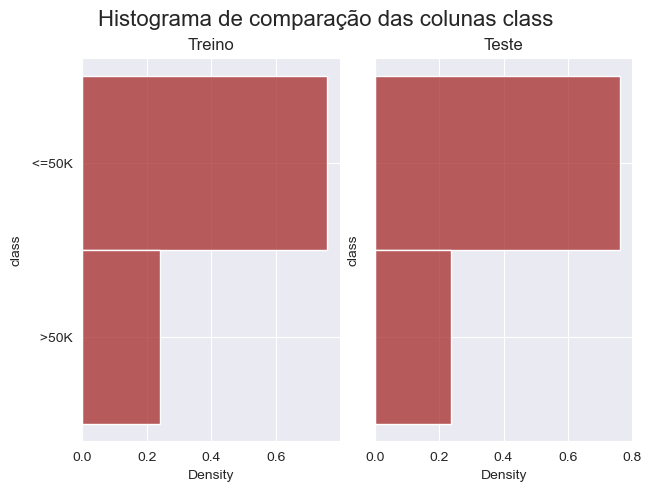

In [17]:
       
for colunas in colunas_cat:
    histograma_de_comparacao(colunas)

# Abaixo de todos os gráficos serão feitas as considerações da distribuição

A diferença dentro desses dados categóricos ainda parece menor entre os dois datasets.

Dessa forma é possível afirmar que os dados do DataFrame de Teste e Treino são confiáveis e podem ser usados para o uso do modelo

### Lidando com os " ?"

In [18]:
# Olhando com atenção o .head do test e nos gráficos acima, foi possível verificar que
#existe um "?" no meio dos dados, vale a pena investigar se além disso existem valores NaN.
# Pela similaridade dos dados utilizarei somente o df_train para fazer as inferências,
#porém as correções serão feitas nos dois dataframes

df_train.isnull().any()

age               False
workclass         False
fnlwgt            False
education         False
education_num     False
marital_status    False
occupation        False
relationship      False
race              False
sex               False
capital_gain      False
capital_loss      False
hours_per_week    False
native_country    False
class             False
dtype: bool

In [19]:
# Confirmarei usando info para também entender melhor os tipos de variáveis existentes

df_train.info()

# Se confirma que não tem valores NaN, porém existem valores com "?" que deveriam ser NaN.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  class           32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [20]:
# Para facilitar o processo, farei uma reload dos dados já transformando o "?" em NaN

df_train = pd.read_csv('adult.data', names=columns, na_values = " ?")
df_test = pd.read_csv('adult.test', names=columns, skiprows= 1, na_values = " ?")

df_train.isnull().any()

age               False
workclass          True
fnlwgt            False
education         False
education_num     False
marital_status    False
occupation         True
relationship      False
race              False
sex               False
capital_gain      False
capital_loss      False
hours_per_week    False
native_country     True
class             False
dtype: bool

In [21]:
# Havia um ' ?' no df_test, farei um .head para confirmar se o reload funcionou 

df_test.head()
# Aqui já foi possível visualizar que o "?" virou um NaN linha 4

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K.


In [22]:
#Retornar somente as colunas com valores NaN e as quantidades de valores NaN

df_train[df_train.columns[df_train.isnull().sum() > 0]].isnull().sum()

workclass         1836
occupation        1843
native_country     583
dtype: int64

In [23]:
# Representação % desses valores NaN dentro das variáveis

(df_train[df_train.columns[df_train.isnull().sum() > 0]].isnull().sum()/df_train.shape[0])*100

workclass         5.638647
occupation        5.660146
native_country    1.790486
dtype: float64

In [24]:
# Entender o quanto esses valores NaN estão distribuidos de acordo com a variável resposta.
# Logo se faz necessário transformar a variável resposta em um 
#dado binário para facilitar análise, compreensão e criação do modelo

var_resp_rename = {' <=50K':0,' >50K': 1}
df_train['class'] = df_train['class'].replace(var_resp_rename)

var_resp_rename_test = {' <=50K.':0,' >50K.': 1}
df_test['class'] = df_test['class'].replace(var_resp_rename_test)


# Separação em dois DataFrames para análise dos NaNs
df_train_menor_50k = df_train[df_train['class'] == 0].reset_index().copy()
df_train_maior_50k = df_train[df_train['class'] == 1].reset_index().copy()

# Printar a % de dados NaN levando em consideração a variável resposta
print(df_train_menor_50k[df_train_menor_50k.columns[df_train_menor_50k.isnull().sum() > 0]].isnull().sum()/df_train_menor_50k.shape[0]*100)
print(df_train_maior_50k[df_train_maior_50k.columns[df_train_maior_50k.isnull().sum() > 0]].isnull().sum()/df_train_maior_50k.shape[0]*100)


workclass         6.654531
occupation        6.682848
native_country    1.767799
dtype: float64
workclass         2.435914
occupation        2.435914
native_country    1.862007
dtype: float64


In [25]:
# Parece que as variáveis resposta 1 tem uma incidencia menor de valores NaN, para fazer o fillna quero testar uma hipótese
#para isso primeiramente farei a visualização de como está a distribuição % dos dados existentes,
#levando em consideração se são variável resposta 0 ou 1 e depois avaliar se após o preenchimento, se mudou muito:


# Visualização das % pré preenchimento
print(pd.concat([df_train_menor_50k.value_counts('workclass',normalize=True)*100,
           df_train_maior_50k.value_counts('workclass',normalize=True)*100],
           axis = 1))


# Preenchimento da coluna com NaN usando a distribuição dos valores
df_train = preenche_coluna(df_train, 'workclass')

# Criação dos novos datasets pós preenchimento separados pela variável resposta
df_train_menor_50k_pos = df_train[df_train['class'] == 0].reset_index().copy()
df_train_maior_50k_pos = df_train[df_train['class'] == 1].reset_index().copy()

# Visualização das % pós preenchimento
print(pd.concat([df_train_menor_50k_pos.value_counts('workclass',normalize=True)*100,
           df_train_maior_50k_pos.value_counts('workclass',normalize=True)*100],
           axis = 1))

                           0          1
workclass                              
 Private           76.849404  64.875817
 Self-emp-not-inc   7.874323   9.464052
 Local-gov          6.396533   8.065359
 State-gov          4.095341   4.614379
 Federal-gov        2.552546   4.849673
 Self-emp-inc       2.140845   8.130719
 Without-pay        0.060672        NaN
 Never-worked       0.030336        NaN
                           0          1
workclass                              
 Private           76.690939  65.029971
 Self-emp-not-inc   7.908576   9.552353
 Local-gov          6.423948   8.034689
 State-gov          4.045307   4.565744
 Federal-gov        2.576861   4.795307
 Self-emp-inc       2.261327   8.021936
 Without-pay        0.064725        NaN
 Never-worked       0.028317        NaN


In [26]:
# Visualização das % pré preenchimento
print(pd.concat([df_train_menor_50k.value_counts('occupation',normalize=True)*100,
           df_train_maior_50k.value_counts('occupation',normalize=True)*100],
           axis = 1))


# Preenchimento da coluna com NaN usando a distribuição dos valores
df_train = preenche_coluna(df_train,'occupation')

# Criação dos novos datasets pós preenchimento separados pela variável resposta
df_train_menor_50k_pos = df_train[df_train['class'] == 0].reset_index().copy()
df_train_maior_50k_pos = df_train[df_train['class'] == 1].reset_index().copy()

# Visualização das % pós preenchimento
print(pd.concat([df_train_menor_50k_pos.value_counts('occupation',normalize=True)*100,
           df_train_maior_50k_pos.value_counts('occupation',normalize=True)*100],
           axis = 1))

                            0          1
occupation                              
 Adm-clerical       14.145136   6.627451
 Craft-repair       13.741980  12.143791
 Other-service      13.689960   1.790850
 Sales              11.561470  12.849673
 Prof-specialty      9.888157  24.300654
 Exec-managerial     9.094850  25.725490
 Machine-op-inspct   7.594937   3.267974
 Handlers-cleaners   5.566152   1.124183
 Transport-moving    5.535807   4.183007
 Farming-fishing     3.810473   1.503268
 Tech-support        2.796081   3.699346
 Protective-serv     1.898734   2.758170
 Priv-house-serv     0.641581   0.013072
 Armed-Forces        0.034680   0.013072
                            0          1
occupation                              
 Adm-clerical       13.988673   6.797602
 Craft-repair       13.624595  12.192322
 Other-service      13.507282   1.964035
 Sales              11.662621  12.855503
 Prof-specialty     10.141586  24.014794
 Exec-managerial     9.405340  25.379416
 Machine-op-insp

In [27]:
# Visualização das % pré preenchimento
print(pd.concat([df_train_menor_50k.value_counts('native_country',normalize=True)*100,
           df_train_maior_50k.value_counts('native_country',normalize=True)*100],
           axis = 1))


# Preenchimento da coluna com NaN usando a distribuição dos valores
df_train = preenche_coluna(df_train,'native_country')

# Criação dos novos datasets pós preenchimento separados pela variável resposta
df_train_menor_50k_pos = df_train[df_train['class'] == 0].reset_index().copy()
df_train_maior_50k_pos = df_train[df_train['class'] == 1].reset_index().copy()

# Visualização das % pós preenchimento
print(pd.concat([df_train_menor_50k_pos.value_counts('native_country',normalize=True)*100,
           df_train_maior_50k_pos.value_counts('native_country',normalize=True)*100],
           axis = 1))

                                     0          1
native_country                                   
 United-States               90.594243  93.190383
 Mexico                       2.512045   0.428850
 Philippines                  0.564181   0.792723
 Puerto-Rico                  0.420047   0.155945
 El-Salvador                  0.399456   0.116959
 Germany                      0.382984   0.571800
 Canada                       0.337685   0.506823
 Jamaica                      0.292386   0.129955
 Cuba                         0.288268   0.324886
 Dominican-Republic           0.280031   0.025991
 South                        0.263559   0.207927
 Vietnam                      0.255323   0.064977
 Guatemala                    0.251205   0.038986
 England                      0.247086   0.389864
 India                        0.247086   0.519818
 Columbia                     0.234732   0.025991
 China                        0.226496   0.259909
 Italy                        0.197669   0.324886


In [28]:
# Usar a função criada para preencher as colunas com valores NaN.

df_test = preenche_coluna(df_test,'workclass')
df_test = preenche_coluna(df_test,'native_country')
df_test = preenche_coluna(df_test,'occupation')

In [29]:
# Checagem de valores NaN

if df_train.isnull().any().sum() + df_test.isnull().any().sum() == 0:
    print("Não existe mais valores NaN")
else:
    print("Nem todos os valores NaN foram preenchidos")

Não existe mais valores NaN


O método foi muito bem sucedido, a distribuição pré e pós preenchimento sofreu quase nenhuma alteração, sendo as mais altas de 0.3, nas três colunas dessa base de Treino, ou seja, ao preencher os dados NaN as distribuições dos dados quase não foram afetados. 

Dessa forma, podemos inferir que o impacto sob um modelo que será gerado será quase nulo.

Além disso, também faz com que não seja necessário excluir dados, que por sua vez quando olhamos para a variável resposta 1 já são muito escassos.

## Análise Exploratória

Nessa fase do estudo, queremos tirar insights relevantes e interessantes sobre a base de dados. Para essa etapa a análise será realizando somente com os dados do DF de treino por representar bem todos os dados.

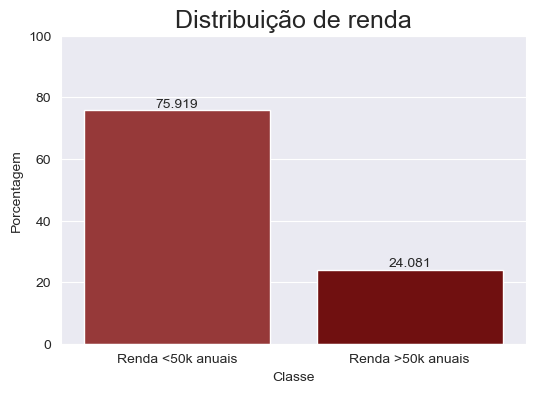

In [30]:
plt.figure(figsize = (6,4))

df_temporario = (df_train['class'].value_counts(normalize = True)*100).rename_axis('Classe').reset_index(name = 'Porcentagem')

ax = sns.barplot(data = df_temporario,
                   x='Classe', y ='Porcentagem',
                   palette = ['brown','maroon'], )

ax.set_title("Distribuição de renda", fontsize=18)

ax.bar_label(ax.containers[0])
ax.set_ylim(0,100)
ax.set_xticklabels(['Renda <50k anuais','Renda >50k anuais'])

plt.show()

A separação dos dados nos permite ver que há um desbalanceamento na base de dados, ou seja, há uma quantidade muito maior da nossa variável resposta 0 do que da variável resposta 1. Futuramente resolveremos essa questão, mas além disso, podemos tirar a conclusão que são poucas pessoas que tem uma renda alta, acima de 50k anuais.

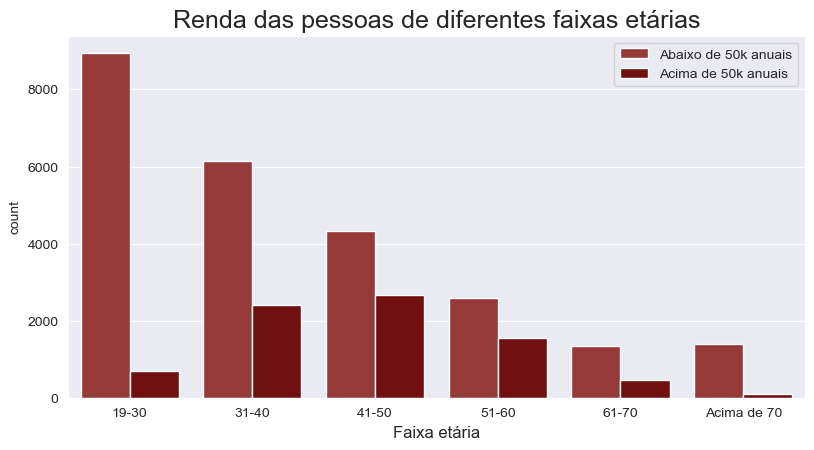

In [31]:
df_temporario = df_train.copy()
df_temporario['faixa_etaria'] = df_temporario['age'].apply(faixa_etarias)

plt.figure(figsize=(9.5,4.7))

ordenacao = ['19-30', '31-40', '41-50', '51-60', '61-70', 'Acima de 70']
ax = sns.countplot(df_temporario['faixa_etaria'], hue = df_temporario['class'], palette=['brown','maroon'], order = ordenacao)
ax.set_title('Renda das pessoas de diferentes faixas etárias', fontsize=18)
ax.set_xlabel('Faixa etária',fontsize=12)
plt.legend(fontsize=10, labels = ['Abaixo de 50k anuais','Acima de 50k anuais'])

plt.show()

- Há uma maior concentração de rendas anuais acima de 50k ficam nas pessoas dentre 30 à 50 anos, após essa idade os valores voltam a cair gradativamente.

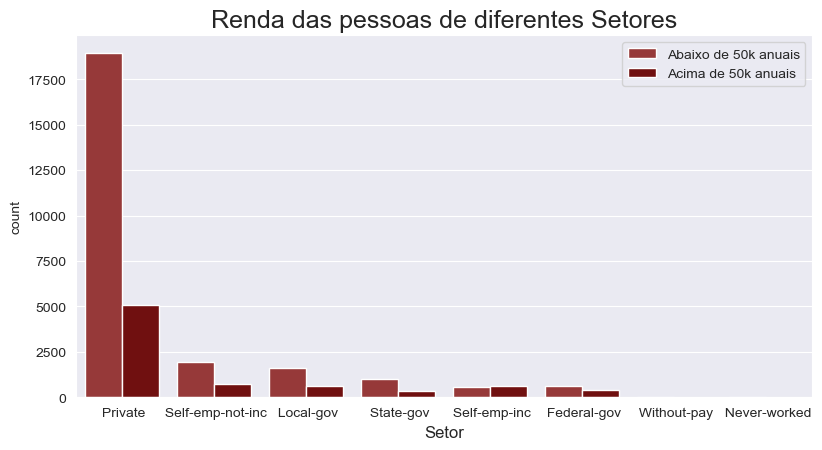

In [32]:
plt.figure(figsize=(9.5,4.7))

# Df_temporario ordenado pela quantidade de recorrencias para gráfico ficar do mais frequente pro menos
df_temporario = df_train.copy()
df_temporario['soma'] = df_temporario.groupby('workclass').workclass.transform('count')
df_temporario = df_temporario.sort_values('soma', ascending=False)

ax = sns.countplot(df_temporario['workclass'], hue = df_temporario['class'], palette=['brown','maroon'])
ax.set_title('Renda das pessoas de diferentes Setores', fontsize=18)
ax.set_xlabel('Setor',fontsize=12)
plt.legend(fontsize=10, labels = ['Abaixo de 50k anuais','Acima de 50k anuais'],loc = 1)

plt.show()

- Aqueles que trabalham no setor privado tem uma representação muito grande no dataset e consequentemente temos também a maior incidência daqueles que recebem mais de 50k anuais quanto dos que não recebem.

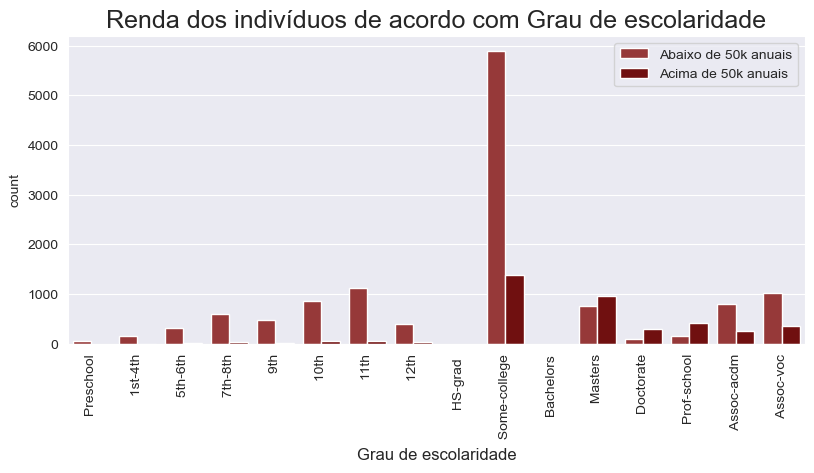

In [33]:
plt.figure(figsize=(9.5,4))

# Ordenando as variáveis para que quanto mais à direita no gráfico, maior é o Grau de escolaridade
ordenacao = [' Preschool', ' 1st-4th', ' 5th-6th', ' 7th-8th', ' 9th', ' 10th', ' 11th', ' 12th', 
             ' HS-grad ', ' Some-college', 'Bachelors', ' Masters', ' Doctorate', ' Prof-school', 
             ' Assoc-acdm', ' Assoc-voc']


ax = sns.countplot(df_train['education'], hue = df_train['class'], palette=['brown','maroon'],order = ordenacao)

ax.set_title('Renda dos indivíduos de acordo com Grau de escolaridade', fontsize=18)
ax.set_xlabel('Grau de escolaridade',fontsize=12)
plt.legend(fontsize=10, labels = ['Abaixo de 50k anuais','Acima de 50k anuais'], loc = 1)
plt.xticks(rotation = 90)

plt.show()

- Os dados "Some-College" são também muito maiores do que a maioria dos outros e concentram a maior parte daqueles que não recebem 50k anuais de renda. 
- Além disso é possível ver que aqueles que tem o Masters, Doctorate e Prof-School são aqueles que mais frequentemente recebem mais de 50k anuais. 
- Por fim, aqueles que não terminaram o HS-Grad ou estiveram antes disso, tem uma quantidade muito pequena de pessoas que recebem mais que 50k e uma quantidade relevantes de quem não recebe.

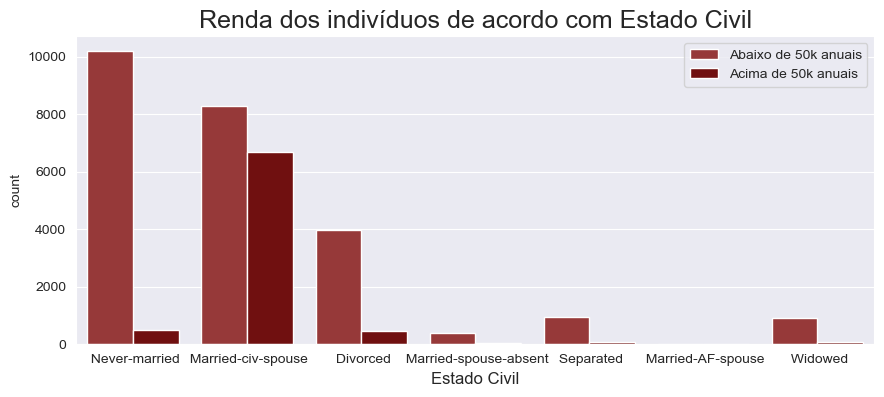

In [34]:
plt.figure(figsize=(10.3,4))

ax = sns.countplot(df_train['marital_status'], hue = df_train['class'], palette=['brown','maroon'])

ax.set_title('Renda dos indivíduos de acordo com Estado Civil', fontsize=18)
ax.set_xlabel('Estado Civil',fontsize=12)
plt.legend(fontsize=10, labels = ['Abaixo de 50k anuais','Acima de 50k anuais'], loc = 1)

plt.show()

- Aqueles que nunca casaram tem uma diferença bem grande de classes de renda
- Married-civ-spouse é a única categoria que tem uma quantidade comparável no número de pessoas dentro das duas categorias da variável resposta.

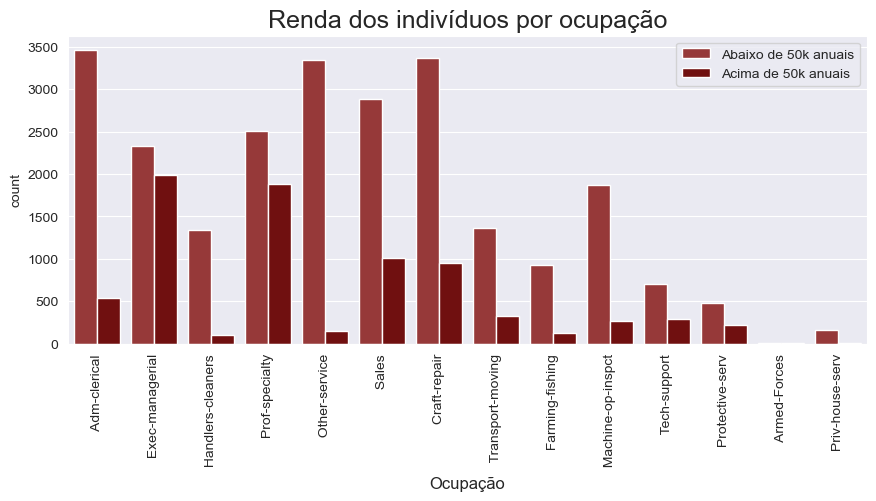

In [35]:
plt.figure(figsize=(10.3,4))

ax = sns.countplot(df_train['occupation'], hue = df_train['class'], palette=['brown','maroon'])

ax.set_title('Renda dos indivíduos por ocupação', fontsize=18)
ax.set_xlabel('Ocupação',fontsize=12)
plt.legend(fontsize=10, labels = ['Abaixo de 50k anuais','Acima de 50k anuais'], loc = 1)
plt.xticks(rotation=90)

plt.show()

- Exec Managerial tem uma quantidade bem próxima de pessoas nas duas categorias
- Prof-speciality está também relativamente perto de uma paridade;
- Ocupações como: Adm-clerical, Other-service e Craft-repair tem uma quantidade bem grande de pessoas que estão na linha de renda abaixo dos 50k anuais

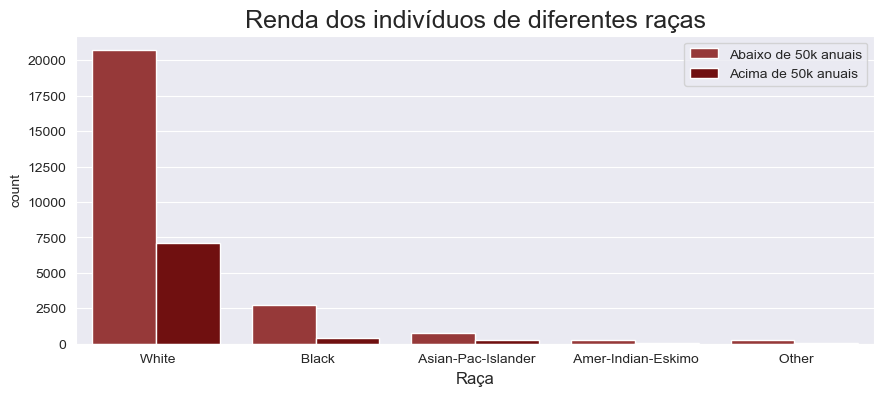

In [36]:
plt.figure(figsize=(10.3,4))

ax = sns.countplot(df_train['race'], hue = df_train['class'], palette=['brown','maroon'])

ax.set_title('Renda dos indivíduos de diferentes raças', fontsize=18)
ax.set_xlabel('Raça',fontsize=12)
plt.legend(fontsize=10, labels = ['Abaixo de 50k anuais','Acima de 50k anuais'], loc = 1)

plt.show()

- A quantidade de individuos Brancos é **bem** maior que todas as outras raças, há pouquíssimas outras entradas de outras raças.
    - Brancos: 27.816 individuos
    - Pretos: 3.124 individuos
    - Asia-Pacífico: 1.039 individuos
    - Amerindio-Eskimos: 311
    - Outros: 271
    
Ou seja, brancos são 85% de todo dataset, isso é um grande enviesamento dessa base e também do modelo que será gerado. Cabe a futuros levantamentos gerar dados mais completos sobre isso, ou possívelmente a exclusão desse dado.

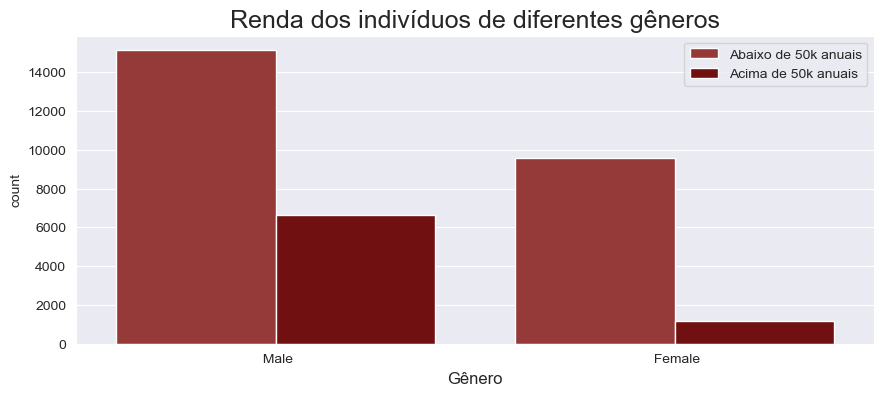

In [37]:
plt.figure(figsize=(10.3,4))

ax = sns.countplot(df_train['sex'], hue = df_train['class'], palette=['brown','maroon'])

ax.set_title('Renda dos indivíduos de diferentes gêneros', fontsize=18)
ax.set_xlabel('Gênero',fontsize=12)
plt.legend(fontsize=10, labels = ['Abaixo de 50k anuais','Acima de 50k anuais'], loc = 1)

plt.show()

No gráfico fica claro o gap de gênero quando falamos de renda por gêneros

- Para mulheres, há menos de 10% de individuos recebendo mais de 50k anuais.
- Já os homens são um pouco mais de 30% recebendo mais de 50k anuais

In [38]:
# A coluna class não é mais categórica, logo pode ser retirada dessa listagem
colunas_cat = ['workclass',
               'education',
               'marital_status',
               'occupation',
               'relationship',
               'race',
               'sex',
               'native_country']

# Transformando nossos dados em dummies para poder gerar a matrix de correlação
df_train_com_dummies = pd.get_dummies(data = df_train, columns = colunas_cat)
df_test_com_dummies = pd.get_dummies(data = df_test, columns = colunas_cat)

df_train_com_dummies

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,class,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,...,native_country_ Portugal,native_country_ Puerto-Rico,native_country_ Scotland,native_country_ South,native_country_ Taiwan,native_country_ Thailand,native_country_ Trinadad&Tobago,native_country_ United-States,native_country_ Vietnam,native_country_ Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,257302,12,0,0,38,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32557,40,154374,9,0,0,40,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32558,58,151910,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32559,22,201490,9,0,0,20,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [39]:
serie = df_train_com_dummies.corr().abs().unstack().sort_values(ascending=False)[df_train_com_dummies.corr().abs().unstack().sort_values(ascending=False) < 1]
print("Correlações maiores que 0.4 (positivas ou negativas)")
serie[serie > 0.4]

Correlações maiores que 0.4 (positivas ou negativas)


sex_ Male                           sex_ Female                           1.000000
sex_ Female                         sex_ Male                             1.000000
marital_status_ Married-civ-spouse  relationship_ Husband                 0.893210
relationship_ Husband               marital_status_ Married-civ-spouse    0.893210
race_ Black                         race_ White                           0.788747
race_ White                         race_ Black                           0.788747
marital_status_ Never-married       marital_status_ Married-civ-spouse    0.644866
marital_status_ Married-civ-spouse  marital_status_ Never-married         0.644866
relationship_ Husband               sex_ Male                             0.580135
sex_ Male                           relationship_ Husband                 0.580135
relationship_ Husband               sex_ Female                           0.580135
sex_ Female                         relationship_ Husband                 0.580135
rela

Boa parte das correlações que considerei relevantes >0.4 (independente de serem positivas ou negativas) se dão numa relação de oposição ou de extrema semelhança exemplos:
- Gênero Feminino e Masculino, correlação de -1.
- Estado civil Casado e ser Marido, correlação de 0.89

Somente as seguintes correlações se mostraram interessantes nesse levantamento de correlação:
- Idade e Estado Civil de Nunca casado -0.53, nesse caso faz sentido uma vez que o casamento geralmente se dá mais velho, logo quanto mais velhor menor a chance da pessoa não ter se casado;
- A variável resposta 'class' aparece com uma correlação de 0.4 quando se é um marido, o que faz bastante sentido, uma vez que quando analisamos os gráficos vimos que estar casado e ser homem tem incidência alta entre os que recebem mais de 50k de renda anual;
- A variável resposta 'class' tem uma correlação de 0.44 com quem é casado, isso corrobora a afirmação acima.

Um ponto de reflexão é que é importante refletir o quanto esses pontos são causais ou ocorrências por outros fatores?

O estado civil parece ter relação alta com o fato de receber mais de 50k anuais de renda ou não, a reflexão importante é se isso se dá por si só ou se temos outros fatores que fazem parte desse fator? Por exemplo é mais comum percentualmente pessoas por volta dos seus 30/40 anos estarem casadas do que as de 20 anos e aqueles com 20 anos geralmente estão em inicio de carreira, enquanto quem tem 30/40 anos tem uma estabilidade profissional maior e com uma carreira mais longa. 

Além disso, a coleta de dados ocorreu nos anos 90 e naquele contexto não havia nenhum tipo de ação referente à diversidade dentro das empresas, logo majoritariamente a amostra desse estudo é enviesada para Homens Brancos, uma vez que os mesmos representam uma quantidade bem maior de participação nesse estudo e no ambiente de trabalho em tal periodo.

Vale refletir para um futuro estudo como poderia ser possível isolar as variáveis e suas influências e também como diversificar a base de dados para o estudo.

## Balanceamento dos dados

A variável resposta 'class' está desbalanceada, é importante balanceá-la para poder ter um modelo melhor. Primeiro farei o modelo dessa forma mesmo e usar os métodos de balanceamento para validar o quanto foi melhorado.

### Benchmark

In [40]:
modelo1 = LogisticRegression()
modelo2 = SVC()
modelo3 = DecisionTreeClassifier()
modelo4 = RandomForestClassifier()

In [41]:
# Separar as variáveis independentes das explicativas e treino e teste

x_train = df_train_com_dummies[df_test_com_dummies.drop('class',axis=1).columns] # O df_train tinha uma coluna de país a mais, e foi removida aqui
y_train = df_train_com_dummies['class']
x_test = df_test_com_dummies.drop('class',axis=1)
y_test = df_test_com_dummies['class']

In [42]:
# Criação do modelo simples de regressão logística para parâmetro
modelo1.fit(x_train,y_train)
y_pred = modelo1.predict(x_test)

# Métricas da 'qualidade' do modelo
print('Modelo usando Regressão Logística')
print("Acurácia:",accuracy_score(y_test, y_pred))
print("Precisão:",precision_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred)) 
print("F1:",f1_score(y_test, y_pred))

Modelo usando Regressão Logística
Acurácia: 0.7978011178674529
Precisão: 0.6915629322268326
Recall: 0.26001040041601664
F1: 0.37792894935752075


In [43]:
modelo2.fit(x_train,y_train)
y_pred = modelo2.predict(x_test)

# Métricas da 'qualidade' do modelo
print('Modelo usando SVC')
print("Acurácia:",accuracy_score(y_test, y_pred))
print("Precisão:",precision_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred)) 
print("F1:",f1_score(y_test, y_pred))

Modelo usando SVC
Acurácia: 0.7985995946194951
Precisão: 0.968595041322314
Recall: 0.15236609464378575
F1: 0.26331161536733316


In [44]:
modelo3.fit(x_train,y_train)
y_pred = modelo3.predict(x_test)

# Métricas da 'qualidade' do modelo
print('Modelo usando árvore de decisão')
print("Acurácia:",accuracy_score(y_test, y_pred))
print("Precisão:",precision_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred)) 
print("F1:",f1_score(y_test, y_pred))

Modelo usando árvore de decisão
Acurácia: 0.813095018733493
Precisão: 0.6021368608496566
Recall: 0.6154446177847114
F1: 0.6087180146586088


In [45]:
modelo4.fit(x_train,y_train)
y_pred = modelo4.predict(x_test)

# Métricas da 'qualidade' do modelo
print('Modelo usando random forest')
print("Acurácia:",accuracy_score(y_test, y_pred))
print("Precisão:",precision_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred)) 
print("F1:",f1_score(y_test, y_pred))

Modelo usando random forest
Acurácia: 0.8511762176770469
Precisão: 0.7203468566119542
Recall: 0.6047841913676547
F1: 0.6575265017667844


O melhor modelo em si foi o RandomForest e será usado para entender quais métodos, ou método de balanceamento funciona melhor.

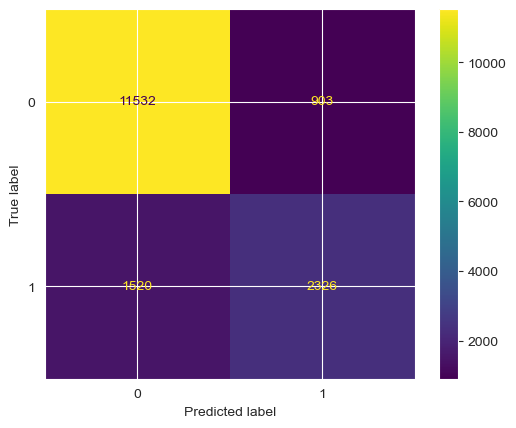

In [46]:
# Plotar a matrix de confusão para visualizar como que o modelo foi

cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp.plot();

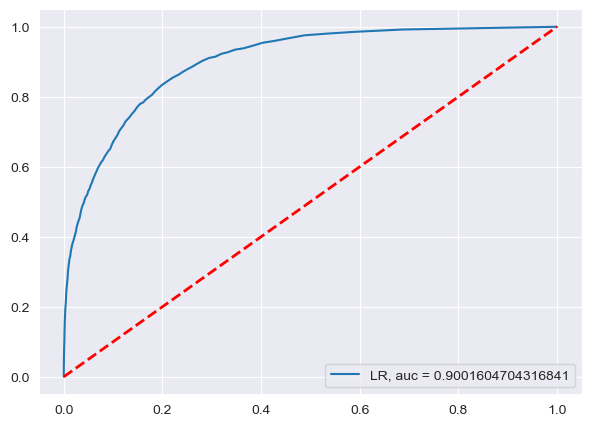

In [47]:
y_pred_proba = modelo4.predict_proba(x_test)[::,1]
fpr,tpr,_= roc_curve(y_test,y_pred_proba)
auc = roc_auc_score(y_test,y_pred_proba)

plt.rcParams['figure.figsize'] = (7,5)
plt.plot(fpr,tpr, label = 'LR, auc = '+str(auc))
plt.plot([0,1],[0,1], color = 'red', lw = 2, linestyle='--')
plt.legend(loc=4);

Nas métricas já foi possível ver que o modelo em si performou muito bem, mesmo sem um balanceamento. A matriz de confusão deixou mais claro ainda, especialmente na quantidade de False Positivos, que foram baixos. A AUC teve também um score bom, mas ainda com espaço para melhora.

A ideia agora é tentar balancear os dados e verificar se é possível melhorar a performance desse modelo que já está performando bem.

### SMOTE

In [48]:
# Começando pelo oversampling 
smote = SMOTE(random_state=42)

x_smote, y_smote = smote.fit_resample(x_train,y_train)

In [49]:
# Verificar se o oversampling funcionou
pd.concat([x_smote, y_smote],axis =1).value_counts('class')

class
0    24720
1    24720
dtype: int64

In [50]:
# Temos agora um valor igual de amostras para as duas variáveis respostas
# A ideia é rodar o modelo novamente e entender se temos uma melhora de performance

modelo = RandomForestClassifier()

# Criação do modelo simples de regressão logística para parâmetro
modelo.fit(x_smote,y_smote)
y_pred = modelo.predict(x_test)

# Métricas da 'qualidade' do modelo
print("Acurácia:",accuracy_score(y_test, y_pred))
print("Precisão:",precision_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred)) 
print("F1:",f1_score(y_test, y_pred))

Acurácia: 0.8476752042257847
Precisão: 0.6945868945868946
Recall: 0.6339053562142486
F1: 0.6628602501359434


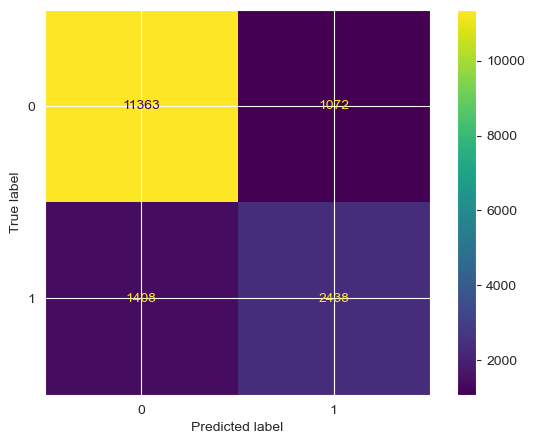

In [51]:
# Plotar a matrix de confusão para visualizar como que o modelo foi

cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

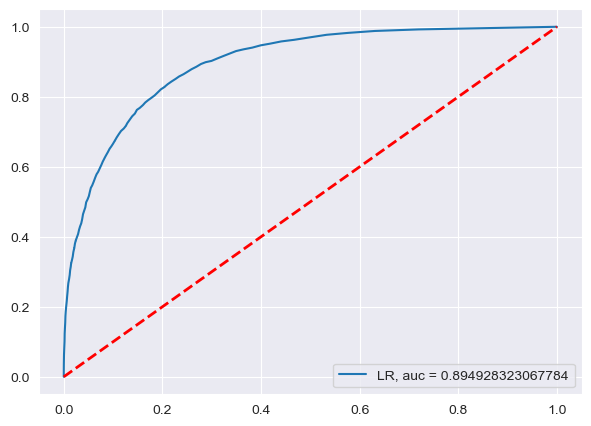

In [52]:
# Geração do gráfico de curva ROC para avaliar a AUC

y_pred_proba = modelo.predict_proba(x_test)[::,1]
fpr,tpr,_= roc_curve(y_test,y_pred_proba)
auc = roc_auc_score(y_test,y_pred_proba)

plt.rcParams['figure.figsize'] = (7,5)
plt.plot(fpr,tpr, label = 'LR, auc = '+str(auc))
plt.plot([0,1],[0,1], color = 'red', lw = 2, linestyle='--')
plt.legend(loc=4);

O Método usado não tornou o modelo melhor, na verdade pareceu um pouco pior até. Algumas das métricas melhoraram, como Recall e F1, mas tanto acurácia, precisão e AUC tiveram scores menores que o modelo de benchmark. A distribuição de valores na matriz de confusão tbm não foram melhores.


Pelas Métricas não fica tão claro se o uso do SMOTE melhorou o modelo, algumas métricas parecem ter melhorado porém outras piorado. Vale a pena tentar outro método de balanceamento, ainda de oversampling, porém um mais conservador o "ADASYN".

### ADASYN

In [53]:
ada = ADASYN(random_state=42)

x_ada, y_ada = ada.fit_resample(x_train, y_train)

modelo = RandomForestClassifier()

# Criação do modelo simples de regressão logística para parâmetro
modelo.fit(x_ada,y_ada)
y_pred = modelo.predict(x_test)

# Métricas da 'qualidade' do modelo
print("Acurácia:",accuracy_score(y_test, y_pred))
print("Precisão:",precision_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred)) 
print("F1:",f1_score(y_test, y_pred))

Acurácia: 0.8452183526810393
Precisão: 0.6877123442808607
Recall: 0.6315652626105044
F1: 0.6584440227703984


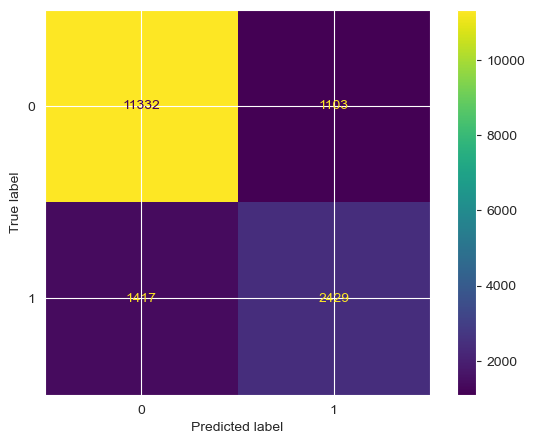

In [54]:
# Plotar a matrix de confusão para visualizar como que o modelo foi

cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

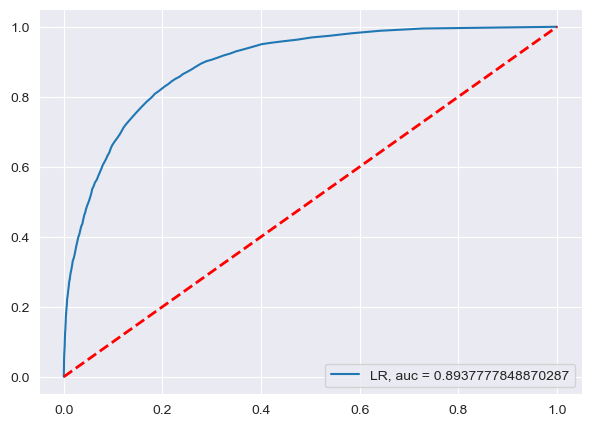

In [55]:
# Geração do gráfico de curva ROC para avaliar a AUC

y_pred_proba = modelo.predict_proba(x_test)[::,1]
fpr,tpr,_= roc_curve(y_test,y_pred_proba)
auc = roc_auc_score(y_test,y_pred_proba)

plt.rcParams['figure.figsize'] = (7,5)
plt.plot(fpr,tpr, label = 'LR, auc = '+str(auc))
plt.plot([0,1],[0,1], color = 'red', lw = 2, linestyle='--')
plt.legend(loc=4);

Esse método não parece ter gerado um valor muito diferente do SMOTE. Similarmente ao SMOTE o método fez sim com que tivessem mais Verdadeiros Positivos, porém não em uma quantidade significante.

### ENN

In [56]:
enn = EditedNearestNeighbours()

x_enn, y_enn = enn.fit_resample(x_train, y_train)

modelo = RandomForestClassifier()

# Criação do modelo simples de regressão logística para parâmetro
modelo.fit(x_enn,y_enn)
y_pred = modelo.predict(x_test)

# Métricas da 'qualidade' do modelo
print("Acurácia:",accuracy_score(y_test, y_pred))
print("Precisão:",precision_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred)) 
print("F1:",f1_score(y_test, y_pred))

Acurácia: 0.8277747067133469
Precisão: 0.6051251008878128
Recall: 0.7797711908476339
F1: 0.6814360372642582


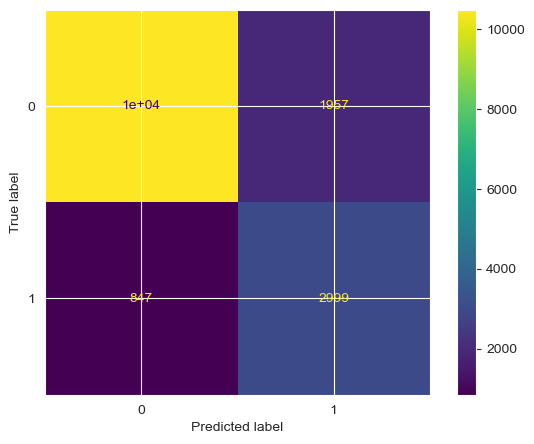

In [57]:
# Plotar a matrix de confusão para visualizar como que o modelo foi

cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

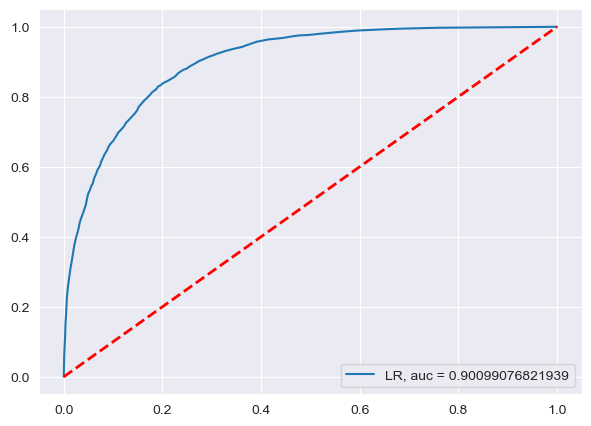

In [58]:
# Geração do gráfico de curva ROC para avaliar a AUC

y_pred_proba = modelo.predict_proba(x_test)[::,1]
fpr,tpr,_= roc_curve(y_test,y_pred_proba)
auc = roc_auc_score(y_test,y_pred_proba)

plt.rcParams['figure.figsize'] = (7,5)
plt.plot(fpr,tpr, label = 'LR, auc = '+str(auc))
plt.plot([0,1],[0,1], color = 'red', lw = 2, linestyle='--')
plt.legend(loc=4);

Essa técnica parece ter dado bons resultados, a quantidade de falsos negativos reduziu, porém a quantidade de falsos positivos aumentou. De forma geral algumas métricas apresentaram melhoras quando esse método foi usado, mas nada que mude muito o resultado do modelo.

Pela natureza de como o método do ENN funciona, quero fazer um último teste que seria unificar as técnicas de ENN, de fazer uma redução de "barulho" da amostra majoritária e aumentando a amostra minoritária usando o ADASYN que teve um bom desempenho no teste.

### ENN -> ADASYN

In [59]:
ada_2 = ADASYN(random_state=6545)

# Pegar as amostrasa usadas 
x_ada_2, y_ada_2 = ada_2.fit_resample(x_enn, y_enn)

modelo = RandomForestClassifier()

# Criação do modelo simples de regressão logística para parâmetro
modelo.fit(x_ada_2,y_ada_2)
y_pred = modelo.predict(x_test)

# Métricas da 'qualidade' do modelo
print("Acurácia:",accuracy_score(y_test, y_pred))
print("Precisão:",precision_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred)) 
print("F1:",f1_score(y_test, y_pred))

Acurácia: 0.8237823229531356
Precisão: 0.5955407784079797
Recall: 0.7917316692667706
F1: 0.6797633664471481


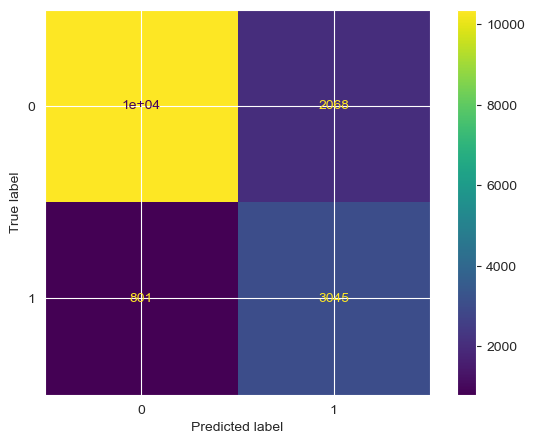

In [60]:
# Plotar a matrix de confusão para visualizar como que o modelo foi

cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

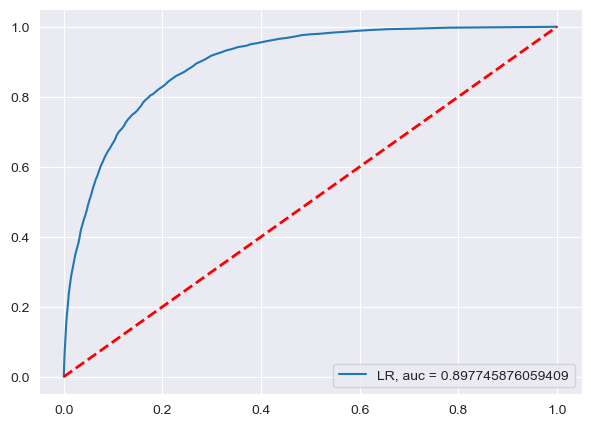

In [61]:
# Geração do gráfico de curva ROC para avaliar a AUC

y_pred_proba = modelo.predict_proba(x_test)[::,1]
fpr,tpr,_= roc_curve(y_test,y_pred_proba)
auc = roc_auc_score(y_test,y_pred_proba)

plt.rcParams['figure.figsize'] = (7,5)
plt.plot(fpr,tpr, label = 'LR, auc = '+str(auc))
plt.plot([0,1],[0,1], color = 'red', lw = 2, linestyle='--')
plt.legend(loc=4);

### ADASYN -> ENN

In [62]:
enn_2 = EditedNearestNeighbours()

x_enn_2, y_enn_2 = enn_2.fit_resample(x_ada, y_ada)

modelo = RandomForestClassifier()

# Criação do modelo simples de regressão logística para parâmetro
modelo.fit(x_enn_2,y_enn_2)
y_pred = modelo.predict(x_test)

# Métricas da 'qualidade' do modelo
print("Acurácia:",accuracy_score(y_test, y_pred))
print("Precisão:",precision_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred)) 
print("F1:",f1_score(y_test, y_pred))

Acurácia: 0.8481665745347338
Precisão: 0.8013157894736842
Recall: 0.4750390015600624
F1: 0.5964740450538688


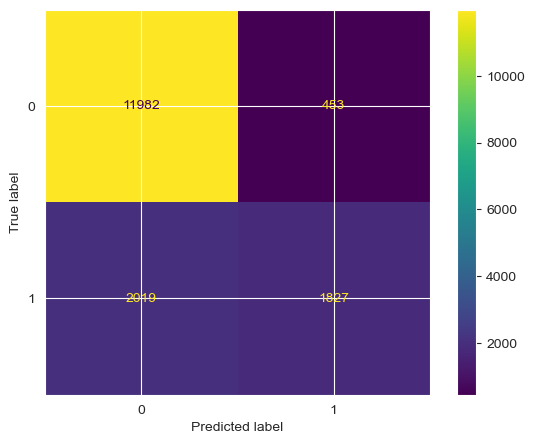

In [63]:
# Plotar a matrix de confusão para visualizar como que o modelo foi

cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

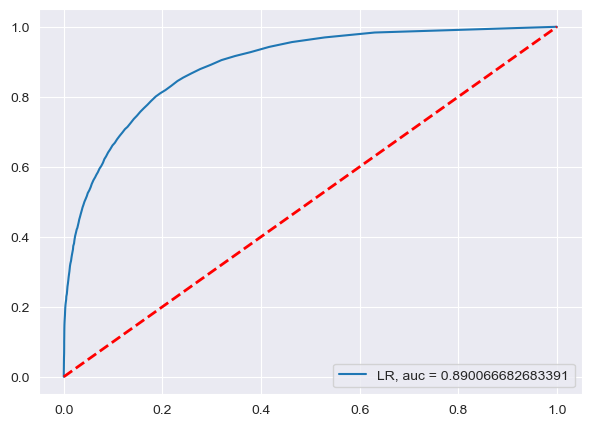

In [64]:
# Geração do gráfico de curva ROC para avaliar a AUC

y_pred_proba = modelo.predict_proba(x_test)[::,1]
fpr,tpr,_= roc_curve(y_test,y_pred_proba)
auc = roc_auc_score(y_test,y_pred_proba)

plt.rcParams['figure.figsize'] = (7,5)
plt.plot(fpr,tpr, label = 'LR, auc = '+str(auc))
plt.plot([0,1],[0,1], color = 'red', lw = 2, linestyle='--')
plt.legend(loc=4);

Na tentativa de unificar os dois métodos (ENN e ADASYN) o resultado não foi positivo ou gerou uma melhora insignificante em relação à o que já havia sido desenvolvido anteriormente.

Nesse sentido esses método de tentativa de realizar um over&under sampling não funcionou.

### Melhor desempenho

Pensando somente nas métricas e scores gerados pelas bibliotecas, não houve um método de balanceamento que trouxr um ganho muito relevante ou significativo para o modelo, uma vez que em algumas métricas o modelo de benchmark performou melhor. 

Porém quando olhamos para a matriz de confusão do **SMOTE**, trouxe um equilibrio um pouco maior para os Falsos Negativos e Falsos Positivos, ou seja, não enviesando o modelo para uma direção que gere mais 0 ou 1.

## Considerações Finais

Relembrando as tarefas desse projeto:
- Carregar a base de dados adult.data e adult.test
    - Foi feito com sucesso. Sendo usado desde o início até a fase final de teste de modelos;
- Realizar uma análise inicial dos dados: Quais foram os problemas encontrado? Como tratar os problemas?
    - A primeira hipótese que tive era que os dados presentes no dataset de treino poderia ser diferente do dataset de teste, foram feitos algumas comparações para comprovar se isso se comprovava, mas no caso não, os dataset de treino e teste tinham distribuições de dados bem similares;
    - Foi encontrado um problema com dados preenchidos com ? ao invés de NaN ou um outro valor real, nesse sentido foi necessário tomar uma decisão se aqueles dados seriam apagados ou preenchidos de alguma forma. Como já tinha percebido que a base de dados era desbalanceada, retirar dados seria uma escolha ruim. Então utilizei um método para preencher os campos ? de forma aleatória preservando a distribuição dos valores daquelas variáveis.
- Fazer uma análise exploratória dos dados: Quais informações interessantes encontrei. (ex: distribuições de variáveis, outliers, correlações, etc)
    - Foi possível gerar vários gráficos exibindo como se dão as relações daqueles que recebem +50k anuais e daqueles que não recebem. Onde há uma maior recorrência de cada um dos dados resposta;
    - Na análise de correlações foi possível destacar duas correlações relevantes para ter a renda anual de >50k, ser "Marido" e ser "Casado".
- A base de dados é desbalanceada para a variável resposta "class". Usar uma técnica para balancear os dados, justificando a escola.
    - Foram usadas 3 técnicas separadamente e a junção de duas delas num único processo. A diferença gerada foi sútil, porém usando o método SMOTE, o modelo conseguiu reduzir um pouco os viéses pois estava gerando Falsos positivos e Falsos Negativos mais equilibrados. Porém a melhora não parece significativa o suficiente para ser um método que valha a pena ser usado em Produção, uma vez que a melhora é quase insignificante.
    
De uma forma geral o desafio foi bem interessante e proporcionou uma experiência que me permitiu me aprofundar em detalhes que não entrava em contato há algum tempo.  